In [31]:
# Cell 1: Load and convert Fashion MNIST dataset to a DataFrame
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from sklearn.manifold import TSNE

### Pretend we are NOT doing this - imagine it being you donwloading data from the internet

In [2]:
# Download and load the Fashion MNIST dataset
transform = transforms.ToTensor()  # Transform the data into tensors
full_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)

In [3]:
# Convert the dataset to a DataFrame
# Each image is a 28x28 array, flatten it into a single row
data_list = []
for image, label in full_dataset:
    flat_image = image.view(-1).numpy()  # Flatten the 28x28 image into a 1D array
    data_list.append([*flat_image, label])

# Create a DataFrame
columns = [f"pixel_{i}" for i in range(28 * 28)] + ["label"]
full_df = pd.DataFrame(data_list, columns=columns)

# Split the DataFrame into train and test sets
train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=42)

# Display the first few rows of each DataFrame
print("Train DataFrame:")
print(train_df.head())
print("\nTest DataFrame:")
print(test_df.head())

Train DataFrame:
       pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  \
48572      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
38696      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
13611      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
35213      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
31766      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel_7   pixel_8   pixel_9  ...  pixel_775  pixel_776  pixel_777  \
48572  0.000000  0.000000  0.000000  ...   0.000000   0.000000   0.000000   
38696  0.000000  0.000000  0.000000  ...   0.003922   0.000000   0.000000   
13611  0.000000  0.000000  0.000000  ...   0.000000   0.000000   0.000000   
35213  0.000000  0.000000  0.011765  ...   0.501961   0.576471   0.658824   
31766  0.011765  0.223529  0.368627  ...   0.000000   0.000000   0.000000   

       pixel_778  pixel_779  pixel_780  pixel_781  pixel_782  pixel_783  label  
48572 

### Let's start here by examining the data

In [4]:
train_df = pd.DataFrame(data_list, columns=columns)

# Display the first few rows of the DataFrame
train_df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,label
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,9
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.000000,...,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,...,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129412,0.376471,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0


In [5]:
train_df.shape, test_df.shape

((60000, 785), (12000, 785))

In [6]:
train_df.max()

pixel_0      0.062745
pixel_1      0.141176
pixel_2      0.466667
pixel_3      0.643137
pixel_4      0.878431
               ...   
pixel_780    1.000000
pixel_781    1.000000
pixel_782    1.000000
pixel_783    0.666667
label        9.000000
Length: 785, dtype: float64

## Helper to visualize a row of data - nice for images

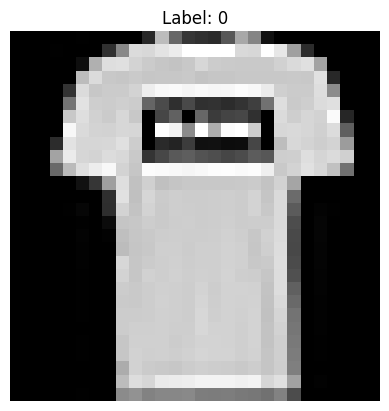

In [7]:
# Cell 8: Function to display a greyscale image from a row
def show_image_from_row(row, label):
    # Reshape the row back to a 28x28 image
    image = np.array(row).reshape(28, 28)
    
    # Plot the image
    plt.imshow(image, cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()

# Example: Display an image from the DataFrame
example_row = train_df.iloc[1, :-1]  # First row (pixels only)
example_label = train_df.iloc[1, -1]  # Corresponding label
show_image_from_row(example_row, example_label)


In [8]:
# Labels

# Each training and test example is assigned to one of the following labels:

# 0 T-shirt/top
# 1 Trouser
# 2 Pullover
# 3 Dress
# 4 Coat
# 5 Sandal
# 6 Shirt
# 7 Sneaker
# 8 Bag
# 9 Ankle boot

## Example Dataloader

In [9]:

# Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        """
        Initialize the dataset by passing a DataFrame.
        Args:
            dataframe (pd.DataFrame): DataFrame with pixel data and labels.
        """
        self.data = dataframe.iloc[:, :-1].values  # Features (all columns except the last)
        self.labels = dataframe.iloc[:, -1].values  # Labels (last column)

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve a single sample from the dataset.
        Args:
            idx (int): Index of the sample to retrieve.
        Returns:
            (torch.Tensor, torch.Tensor): Tuple of features and label.
        """
        # Convert the features and label to tensors
        features = torch.tensor(self.data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return features, label



In [10]:
# Function to split the DataFrame and create DataLoaders
def create_train_test_dataloaders(dataframe, test_size=0.2, batch_size=64, shuffle=True):
    """
    Split the DataFrame into train and test sets and create DataLoaders.
    Args:
        dataframe (pd.DataFrame): DataFrame containing the data.
        test_size (float): Proportion of the data to be used as test data.
        batch_size (int): Number of samples per batch.
        shuffle (bool): Whether to shuffle the data.
    Returns:
        tuple: (train_loader, test_loader)
    """
    # Split the data into train and test sets
    train_df, test_df = train_test_split(dataframe, test_size=test_size, random_state=42)
    
    # Create train and test datasets
    train_dataset = CustomDataset(train_df)
    test_dataset = CustomDataset(test_df)
    
    # Create DataLoaders for train and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [11]:
# ## command + /

# # Example usage: Creating train and test DataLoaders
# train_loader, test_loader = create_train_test_dataloaders(train_df, test_size=0.2, batch_size=32)

# # Example: Check the first batch from the train DataLoader
# for batch_idx, (features, labels) in enumerate(train_loader):
#     print(f"Train Batch {batch_idx + 1}")
#     print("Features shape:", features.shape)
#     print("Labels shape:", labels.shape)
#     break  # Display only the first batch

# # Example: Check the first batch from the test DataLoader
# for batch_idx, (features, labels) in enumerate(test_loader):
#     print(f"Test Batch {batch_idx + 1}")
#     print("Features shape:", features.shape)
#     print("Labels shape:", labels.shape)
#     break  # Display only the first batch

## Manually Build dataloaders

In [54]:
# Cell 2: Create a DataLoader


# Convert the DataFrame back to PyTorch tensors
X_train = torch.tensor(train_df.iloc[:, :-1].values, dtype=torch.float32)  # All pixels
y_train = torch.tensor(train_df["label"].values, dtype=torch.long)  # Labels
# Convert the DataFrame back to PyTorch tensors
X_test = torch.tensor(test_df.iloc[:, :-1].values, dtype=torch.float32)  # All pixels
y_test = torch.tensor(test_df["label"].values, dtype=torch.long)  # Labels

# Create a TensorDataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create a DataLoader for batching and shuffling
batch_size = 32  # Number of samples per batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



In [55]:
# Example: Check the first batch
for batch in train_loader:
    images, labels = batch
    print(f"Batch size: {images.shape}, Labels: {labels.shape}")
    break
# Example: Check the first batch
for batch in test_loader:
    images, labels = batch
    print(f"Batch size: {images.shape}, Labels: {labels.shape}")
    break

Batch size: torch.Size([32, 784]), Labels: torch.Size([32])
Batch size: torch.Size([32, 784]), Labels: torch.Size([32])


In [56]:
# Cell 3: Define the neural network

# Define a feedforward network for classification
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First fully connected layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)  # First layer
        x = self.relu(x)
        x = self.fc2(x)  # Output layer
        return x

# Initialize the model
input_size = 784  # 784 input features (flattened image)
hidden_size = 256  # Number of neurons in the hidden layer
num_classes = 10  # 10 classes for Fashion MNIST

In [57]:
model = SimpleNN(input_size, hidden_size, num_classes)

# Print the model architecture
print(model)

SimpleNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [58]:
# Cell 4: Define hyperparameters
learning_rate = 0.005
num_epochs = 100
#batch_size = 64

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


### for later!

In [59]:
# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )
# model.to("cpu")
# print(f"Using {device} device")


## Model Training

In [60]:
# Training the model
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for rows, labels in train_loader:
        # Forward pass
        outputs = model(rows)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/100], Loss: 1.1290
Epoch [2/100], Loss: 0.6620
Epoch [3/100], Loss: 0.5695
Epoch [4/100], Loss: 0.5235
Epoch [5/100], Loss: 0.4959
Epoch [6/100], Loss: 0.4767
Epoch [7/100], Loss: 0.4620
Epoch [8/100], Loss: 0.4506
Epoch [9/100], Loss: 0.4413
Epoch [10/100], Loss: 0.4324
Epoch [11/100], Loss: 0.4249
Epoch [12/100], Loss: 0.4184
Epoch [13/100], Loss: 0.4123
Epoch [14/100], Loss: 0.4064
Epoch [15/100], Loss: 0.4006
Epoch [16/100], Loss: 0.3957
Epoch [17/100], Loss: 0.3905
Epoch [18/100], Loss: 0.3860
Epoch [19/100], Loss: 0.3820
Epoch [20/100], Loss: 0.3773
Epoch [21/100], Loss: 0.3737
Epoch [22/100], Loss: 0.3698
Epoch [23/100], Loss: 0.3665
Epoch [24/100], Loss: 0.3625
Epoch [25/100], Loss: 0.3592
Epoch [26/100], Loss: 0.3563
Epoch [27/100], Loss: 0.3530
Epoch [28/100], Loss: 0.3493
Epoch [29/100], Loss: 0.3468
Epoch [30/100], Loss: 0.3445
Epoch [31/100], Loss: 0.3414
Epoch [32/100], Loss: 0.3387
Epoch [33/100], Loss: 0.3365
Epoch [34/100], Loss: 0.3340
Epoch [35/100], Loss: 0

## Saving and loading a model

In [63]:
# Save the model after training
torch.save(model.state_dict(), "fashion_mnist_model.pth")
print("Model saved as 'fashion_mnist_model.pth'")


Model saved as 'fashion_mnist_model.pth'


In [64]:
# Load the saved model for inference
model = SimpleNN(input_size, hidden_size, num_classes)  # Reinitialize the model structure
model.load_state_dict(torch.load("fashion_mnist_model.pth"))
model.eval()  # Set the model to evaluation mode
print("Model loaded and ready for inference.")


Model loaded and ready for inference.


In [65]:
# Cell 6: Inference loop
# Running inference
model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for efficiency
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 91.29%


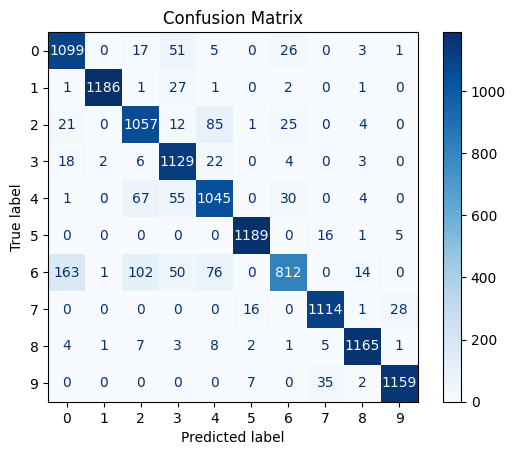

In [66]:

# Generate predictions for the entire dataset
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

# Compute and plot the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### Inspect a row of data

In [67]:
# Helper function to run inference on a single row of data
def run_inference_on_row(row, label, model):
    # Convert the row into a tensor
    row_tensor = torch.tensor(row.values, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        logits = model(row_tensor)  # Raw logits
        probabilities = torch.softmax(logits, dim=1)  # Apply softmax to convert logits to probabilities

    # Get predicted label
    predicted_label = torch.argmax(probabilities).item()

    # Print details
    print("Logits:", logits.numpy())
    print("Softmax Probabilities:", probabilities.numpy())
    print("Correct Label:", label)
    print("Predicted Label:", predicted_label)

    return predicted_label

# Example: Run inference on a single row
example_row = test_df.iloc[10, :-1]  # 10th row (pixels only)
example_label = test_df.iloc[10, -1]  # Corresponding label
run_inference_on_row(example_row, example_label, model)

Logits: [[  6.694144    2.826612    2.7930484   6.051111    2.5235243 -12.698506
    4.121987   -9.459718    3.2623138  -6.527294 ]]
Softmax Probabilities: [[5.9137708e-01 1.2365646e-02 1.1957497e-02 3.1088445e-01 9.1324532e-03
  2.2373987e-09 4.5163848e-02 5.7059950e-08 1.9117879e-02 1.0711916e-06]]
Correct Label: 3
Predicted Label: 0


0

In [68]:
### Display examples of correct and incorrect predictions

In [69]:

def display_examples(data_df, model, correct=True, num_examples=3):
    count = 0
    plt.figure(figsize=(10, 5))

    for idx, row in data_df.iterrows():
        if count >= num_examples:
            break

        # Extract image and label
        image_row = row[:-1]
        true_label = row[-1]

        # Run inference
        predicted_label = run_inference_on_row(image_row, true_label, model)

        # Check if prediction is correct
        if (predicted_label == true_label and correct) or (predicted_label != true_label and not correct):
            # Plot the image
            plt.subplot(1, num_examples, count + 1)
            image = image_row.values.reshape(28, 28)  # Reshape to 28x28
            plt.imshow(image, cmap="gray")
            plt.title(f"True: {true_label}, Pred: {predicted_label}")
            plt.axis("off")
            count += 1






Examples of Correct Predictions:
Logits: [[ -2.557691  -10.17373    -6.560807   -6.880913   -6.659751    8.185889
   -2.6386561   9.191753    1.521682   16.634216 ]]
Softmax Probabilities: [[4.6207549e-09 2.2756734e-12 8.4368880e-11 6.1257853e-11 7.6420655e-11
  2.1408724e-04 4.2613797e-09 5.8537209e-04 2.7312549e-07 9.9920040e-01]]
Correct Label: 9.0
Predicted Label: 9
Logits: [[ 18.872147   -4.1211257   8.554959    6.553858   -1.5522187 -15.580516
   10.548579  -15.116429    3.9600043 -11.865168 ]]
Softmax Probabilities: [[9.99719560e-01 1.03282494e-10 3.30507028e-05 4.46800186e-06
  1.34799638e-09 1.08962382e-15 2.42660331e-04 1.73311591e-15
  3.33900658e-07 4.47540395e-14]]
Correct Label: 0.0
Predicted Label: 0
Logits: [[ 4.768698   1.2220654  1.3927183  4.6762056  2.2489676 -6.0311265
   3.4672506 -4.058495  -1.683608  -5.4863806]]
Softmax Probabilities: [[4.29357708e-01 1.23747448e-02 1.46774240e-02 3.91426504e-01
  3.45552638e-02 8.76022023e-06 1.16844356e-01 6.29822171e-05
  6.

/var/folders/83/s01xl68d2q3gdtkbr5ptq6nc0000gn/T/ipykernel_4978/3303586380.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = row[-1]


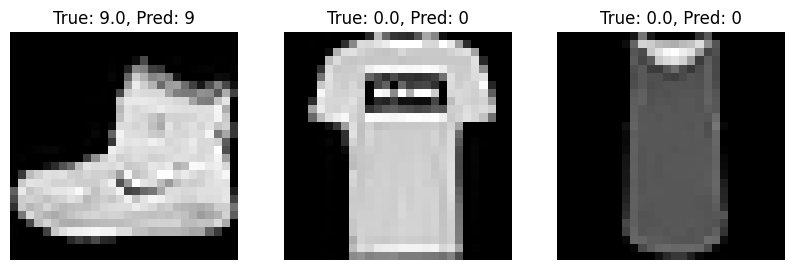

In [70]:
# Example: Show 3 correct predictions
print("Examples of Correct Predictions:")
display_examples(train_df, model, correct=True, num_examples=3)
plt.show()

Examples of Incorrect Predictions:
Logits: [[ -2.557691  -10.17373    -6.560807   -6.880913   -6.659751    8.185889
   -2.6386561   9.191753    1.521682   16.634216 ]]
Softmax Probabilities: [[4.6207549e-09 2.2756734e-12 8.4368880e-11 6.1257853e-11 7.6420655e-11
  2.1408724e-04 4.2613797e-09 5.8537209e-04 2.7312549e-07 9.9920040e-01]]
Correct Label: 9.0
Predicted Label: 9
Logits: [[ 18.872147   -4.1211257   8.554959    6.553858   -1.5522187 -15.580516
   10.548579  -15.116429    3.9600043 -11.865168 ]]
Softmax Probabilities: [[9.99719560e-01 1.03282494e-10 3.30507028e-05 4.46800186e-06
  1.34799638e-09 1.08962382e-15 2.42660331e-04 1.73311591e-15
  3.33900658e-07 4.47540395e-14]]
Correct Label: 0.0
Predicted Label: 0
Logits: [[ 4.768698   1.2220654  1.3927183  4.6762056  2.2489676 -6.0311265
   3.4672506 -4.058495  -1.683608  -5.4863806]]
Softmax Probabilities: [[4.29357708e-01 1.23747448e-02 1.46774240e-02 3.91426504e-01
  3.45552638e-02 8.76022023e-06 1.16844356e-01 6.29822171e-05
  

/var/folders/83/s01xl68d2q3gdtkbr5ptq6nc0000gn/T/ipykernel_4978/3303586380.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = row[-1]


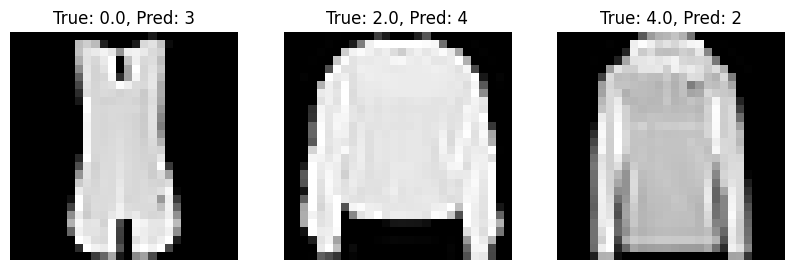

In [71]:
# Example: Show 3 incorrect predictions
print("Examples of Incorrect Predictions:")
display_examples(train_df, model, correct=False, num_examples=3)
plt.show()

In [74]:
def create_tensorboard_visualization(model_path, dataloader, log_dir="runs/fashion_mnist"):
    """
    Reads the trained model, creates a TensorBoard visualization of the data,
    and visualizes the embedding space with labels and images.

    Args:
        model_path (str): Path to the trained model file.
        dataloader (DataLoader): DataLoader for the dataset.
        log_dir (str): Directory where TensorBoard logs will be saved.

    Returns:
        None
    """
    # Load the trained model
    model = SimpleNN(input_size=28*28, hidden_size=256, num_classes=10)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set to evaluation mode
    
    # Initialize TensorBoard writer
    writer = SummaryWriter(log_dir=log_dir)
    
    # Store features and labels for embedding visualization
    features_list = []
    labels_list = []
    images_list = []

    # Collect data from the DataLoader
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            # Get the raw embeddings (output before the final layer)
            embeddings = model.fc1(images)  # Extract embeddings from the first layer
            features_list.append(embeddings)
            labels_list.append(labels)
            images_list.append(images)
    
    # Concatenate all features and labels
    features = torch.cat(features_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    images = torch.cat(images_list, dim=0)
    
    # Log embeddings to TensorBoard
    writer.add_embedding(
        features,
        metadata=labels.numpy(),
        label_img=images.view(-1, 1, 28, 28),  # Reshape to image format
        global_step=0
    )

    # Optionally visualize some sample images in TensorBoard
    grid = make_grid(images[:64].view(-1, 1, 28, 28), nrow=8, normalize=True)
    writer.add_image("FashionMNIST Samples", grid, global_step=0)
    
    # Close the writer
    writer.close()
    print(f"TensorBoard logs saved to: {log_dir}")


In [75]:
create_tensorboard_visualization("fashion_mnist_model.pth", test_loader)

TensorBoard logs saved to: runs/fashion_mnist
